Domain Generalization via Gradient Surgery

Ufuk Altun

The Baseline Model

**Install Julia kernel to Colab**

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.3" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Success! Please reload this page and jump to the next section."
fi

**Check the installation**

In [ ]:
versioninfo()

**Install Knet and other packages**

In [ ]:
using Pkg; 
pkg"add Knet IterTools MLDatasets FileIO Images CUDA"

**Download VLCS dataset**

In [3]:
run(`gdown --id 1skwblH1_okBwxWxmRsp9_qi15hyPpxg8`)

Downloading...
From: https://drive.google.com/uc?id=1skwblH1_okBwxWxmRsp9_qi15hyPpxg8
To: /content/VLCS.tar.gz
100%|#####################################| 3.84G/3.84G [01:14<00:00, 51.4MB/s]


Process(`gdown --id 1skwblH1_okBwxWxmRsp9_qi15hyPpxg8`, ProcessExited(0))

**Unzip the dataset**

In [4]:
#mkdir("/content/VLCS_data")
run(`tar xzf /content/VLCS.tar.gz`)

Process(`tar xzf /content/VLCS.tar.gz`, ProcessExited(0))

**Load packages**

In [5]:
ENV["COLUMNS"]=72
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Statistics: mean
using MLDatasets: MNIST
using FileIO: load, save
using CUDA: CUDA, CuArray # functional
using Knet: Knet, conv4, pool, mat, nll, accuracy, progress, sgd, param, param0, dropout, relu, minibatch, Data
using Knet, IterTools
using Images

**Function definition of read_data that reads data by looping through folders, resizes and loads as xtrn ytrn variables**

**Inspired from the work of Ege Kesim: "Facial Expression Recognition Using Weighted Mixture Deep Neural Network Based on Double-Channel Facial Images" from example projects**

In [6]:
function read_data(data_path,image_size,ssize)
i=1
first_r=true
y=[]
x=0
folders=readdir(data_path)
for class in folders
    println("Class number ",i," ",class)
    directory=string(data_path,"/",class)
    counter = 0
    for img in readdir(directory)
        arr_img=load(string(directory,"/",img))
        #print(size(arr_img))
        if size(arr_img) != image_size
          arr_img = imresize(arr_img, image_size);
        end
        arr_img=channelview(arr_img)
        arr_img = permutedims(arr_img, (2, 3, 1))
        label=zeros(size(folders))
        label[i]=1
        if first_r==false
            x=cat(x,arr_img,dims=4)
        else
            x=cat(arr_img,dims=4)
        end
        push!(y,i)
        first_r=false
        counter = counter + 1;
        if counter == ssize
            break
        end
    end
    i+=1
    end
println(size(y))
println(size(x))
return x,y;
end

read_data (generic function with 1 method)

**Read data by looping through folders, resize and load as xtrn ytrn variables**

In [8]:
xtrn,ytrn=read_data("VLCS/SUN09",(227,227), 400);
xtst,ytst=read_data("VLCS/SUN09",(227,227), 100);

#xtrn,ytrn = MNIST.traindata(Float32); ytrn[ytrn.==0] .= 10
#xtst,ytst = MNIST.testdata(Float32);  ytst[ytst.==0] .= 10

#dtrn = minibatch(xtrn, ytrn, 100; xsize = (28,28,1,:))
#dtst = minibatch(xtst, ytst, 100; xsize = (28,28,1,:));

Class number 1 bird
Class number 2 car
Class number 3 chair
Class number 4 dog
Class number 5 person
(1250,)
(227, 227, 3, 1250)
Class number 1 bird
Class number 2 car
Class number 3 chair
Class number 4 dog
Class number 5 person
(350,)
(227, 227, 3, 350)


**`Save variables that contain resized data`**

In [9]:
save("xtrn.jld2","data",xtrn)
save("ytrn.jld2","data",ytrn)
save("xtst.jld2","data",xtst)
save("ytst.jld2","data",ytst)

**`Load variables that contain resized data`**

In [ ]:
xtrn=load("xtrn.jld2")["data"];
ytrn=load("ytrn.jld2")["data"];
xtst=load("xtst.jld2")["data"];
ytst=load("ytst.jld2")["data"];

**Take minibatches from dataset**

(Knet.minibatch function is called since base minibatch function is unable to take 3 channel input)

In [10]:
dtrn=Knet.minibatch(xtrn,ytrn,100,xtype=Array{Float32},ytype=Array{Int32});
dtst=Knet.minibatch(xtst,ytst,100,xtype=Array{Float32},ytype=Array{Int32});

**Function definition of trainresults that initiates training and outputs loss and accuracy**

In [11]:
# For running experiments
function trainresults(file,model; o...)
    if (print("Train from scratch? "); readline()[1]=='y')
        r = ((model(dtrn), model(dtst), 1-accuracy(model,dtrn), 1-accuracy(model,dtst))
             for x in takenth(progress(sgd(model,ncycle(dtrn,100))),length(dtrn)))
        r = reshape(collect(Float32,flatten(r)),(4,:))
        save(file,"results",r)
        GC.gc(true) # To save gpu memory
    else
        isfile(file) || download("https://github.com/denizyuret/Knet.jl/releases/download/v1.4.9/$file",file)
        r = load(file,"results")
    end
    println(minimum(r,dims=2))
    return r
end

trainresults (generic function with 1 method)

**Definition of Convolution layer, Dense layer and Chain that chains layers**

In [12]:
# Define a convolutional layer:
struct Conv; w; b; f; p; end
(c::Conv)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p)) .+ c.b))
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

# Redefine dense layer (See mlp.ipynb):
struct Dense; w; b; f; p; end
(d::Dense)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(param(o,i), param0(o), f, pdrop)

# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

**Definition of a baseline model**

In [13]:
baseline_model =   Chain(Conv(3,3,3,3), 
                Dense(112*112*3,5,identity,pdrop=0.3))

Chain((Conv(P(Array{Float32, 4}(3,3,3,3)), P(Array{Float32, 4}(1,1,3,1)), Knet.Ops20.relu, 0), Dense(P(Matrix{Float32}(5,37632)), P(Vector{Float32}(5)), identity, 0.3)))

**Training and saving the baseline model**

In [14]:
baseline = trainresults("baseline.jld2", baseline_model);

Train from scratch? stdin> y


┣▏                   ┫ [0.92%, 11/1200, 00:27/49:39, 1.35i/s] ┌ Warning: accuracy(model,data; o...) is deprecated, please use accuracy(model; data=data, o...)
└ @ Knet.Ops20 /root/.julia/packages/Knet/RCkV0/src/ops20/loss.jl:205
┣████████████████████┫ [100.00%, 1200/1200, 29:08/29:08, 1.46s/i] 


Float32[1.2572732; 1.4880441; 0.6666667; 0.6666667]


**Plotting the loss results**

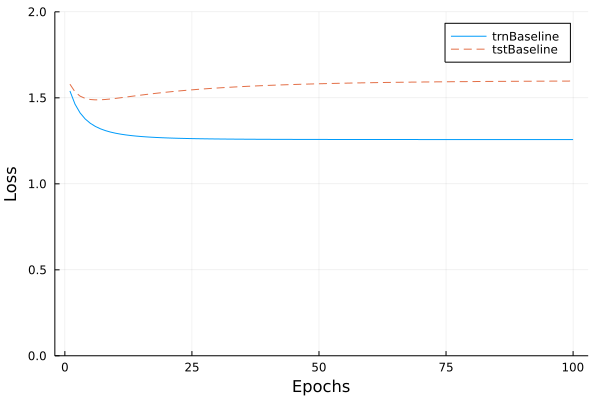

In [16]:
using Plots; default(fmt=:png,ls=:auto)

# Comparison to MLP shows faster convergence, better generalization
plot([baseline[1,:], baseline[2,:]],ylim=(0.0,2),
     labels=["trnBaseline" "tstBaseline"],xlabel="Epochs",ylabel="Loss")